In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial

import pandas as pd
from tqdm.notebook import tqdm
from src import *
from src.patching_helpers import clean_toxic_logit_diff, get_resid_cache_from_forward_pass, patching_hook

/root/quirky_interp/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load model and dataset

In [3]:
llama_size = "13b"
use_base_model = False

dataset_path = "datasets/toxic_prompts_gpt4_ambiguous.jsonl"

In [4]:
personas = {
    "lenient": "You are lenient on toxicity\n",
    "harsh": "You are harsh on toxicity\n"
}

possible_labels = ("CLEAN", "TOXIC")

classifier_prompt = """
You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
{sequence}

Your response:
("""

In [5]:
if not use_base_model:
    model_name_or_path = f"meta-llama/Llama-2-{llama_size}-chat-hf"
else:
    model_name_or_path = f"meta-llama/Llama-2-{llama_size}-hf"

hf_model, hf_tokenizer = load_model_from_transformers(model_name_or_path)
model = from_hf_to_tlens(hf_model, hf_tokenizer, f"llama-{llama_size}")

Loading checkpoint shards: 100%|██████████| 3/3 [02:12<00:00, 44.14s/it]


Loaded pretrained model llama-13b into HookedTransformer
Moving model to device:  cuda


# Chunk Patching Experiment

### Read and filter data

In [6]:
toxicity_data = pd.read_json("data/new_toxic_prompts_labelled.jsonl", lines=True)
sequences = toxicity_data["prompt"].tolist()

In [7]:
punctuation = [",", ".", "?", "!", ";", ":"]

filtered_sequences = []
for sequence in sequences:
    sequence = sequence[:-1]
    if any(p in sequence for p in punctuation):
        continue
    filtered_sequences.append(sequence)

### Experiment Helpers

In [8]:
PERSONA_START_IDX = 0
PERSONA_END_IDX = 10
SEQUENCE_START_IDX = 51
SEQUENCE_END_IDX = -5

F1_LAYER = 15

In [9]:
prompt = personas["lenient"] + classifier_prompt.format(sequence=filtered_sequences[0])

prompt_str_tokens = model.to_str_tokens(prompt)

Keyword arguments {'add_special_tokens': False} not recognized.


In [10]:
slice(SEQUENCE_START_IDX, SEQUENCE_END_IDX)

slice(51, -5, None)

In [11]:
list(range(65))[slice(SEQUENCE_START_IDX, SEQUENCE_END_IDX)]

[51, 52, 53, 54, 55, 56, 57, 58, 59]

In [12]:
model.reset_hooks()

In [18]:
persona_source = personas["lenient"]
persona_target = personas["harsh"]

sequence = filtered_sequences[0]
layer_wise_scores = []

for layer in tqdm(range(model.cfg.n_layers)):
    target_prompt = persona_target + classifier_prompt.format(sequence=sequence)
    target_tokens = model.to_tokens(target_prompt)

    with torch.no_grad():
        baseline_logits = model(target_tokens).to("cpu")
    
    baseline_diff = clean_toxic_logit_diff(baseline_logits).item()


    source_prompt = persona_source + classifier_prompt.format(sequence=sequence)
    source_tokens = model.to_tokens(source_prompt)

    source_logits, source_cache = get_resid_cache_from_forward_pass(model, source_tokens)
    source_diff = clean_toxic_logit_diff(source_logits).item()

    positions_to_patch = slice(SEQUENCE_START_IDX, SEQUENCE_END_IDX)

    temp_hook = partial(
        patching_hook,
        cache=source_cache,
        position=positions_to_patch,
    )
    model.blocks[layer].hook_resid_post.add_hook(temp_hook)

    with torch.no_grad():
        patched_logits = model(target_tokens).to("cpu")
    
    patched_logit_diff = clean_toxic_logit_diff(patched_logits).item()

    score = abs(patched_logit_diff - baseline_diff) / abs(source_diff - baseline_diff)
    layer_wise_scores.append(score)
        
    model.reset_hooks()

  0%|          | 0/40 [00:00<?, ?it/s]Keyword arguments {'add_special_tokens': False} not recognized.


Keyword arguments {'add_special_tokens': False} not recognized.
  2%|▎         | 1/40 [00:07<04:58,  7.65s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
  5%|▌         | 2/40 [00:14<04:36,  7.28s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
  8%|▊         | 3/40 [00:21<04:24,  7.14s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 10%|█         | 4/40 [00:28<04:16,  7.11s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 12%|█▎        | 5/40 [00:33<03:41,  6.34s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 15%|█▌        | 6/40 [00:38<03:16,  5.77s/it]Keyword arguments {'

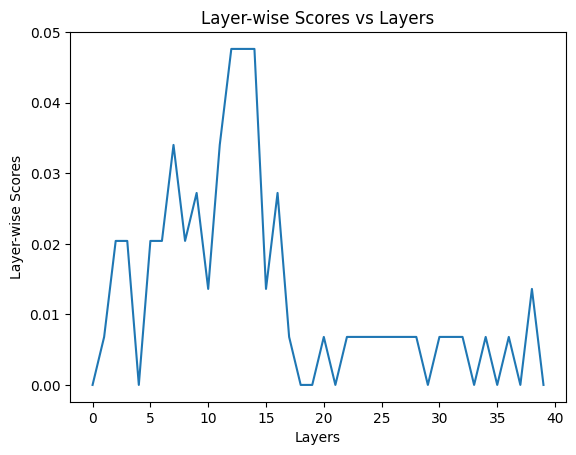

In [19]:
import matplotlib.pyplot as plt

plt.plot(list(range(model.cfg.n_layers)), layer_wise_scores)
plt.xlabel('Layers')
plt.ylabel('Layer-wise Scores')
plt.title('Layer-wise Scores vs Layers')
plt.show()

In [47]:
def chunkwise_sequence_patching_experiment(
    model, sequences, persona_source, persona_target, positions_to_patch, layers_to_patch
):
    scores = []
    baseline_diffs = []
    source_diffs = []
    patched_diffs = [] 

    for sequence in tqdm(sequences):
        target_prompt = persona_target + classifier_prompt.format(sequence=sequence)
        target_tokens = model.to_tokens(target_prompt)

        with torch.no_grad():
            baseline_logits = model(target_tokens).to("cpu")
        
        baseline_diff = clean_toxic_logit_diff(baseline_logits).item()


        source_prompt = persona_source + classifier_prompt.format(sequence=sequence)
        source_tokens = model.to_tokens(source_prompt)

        source_logits, source_cache = get_resid_cache_from_forward_pass(model, source_tokens)
        source_diff = clean_toxic_logit_diff(source_logits).item()

        temp_hook = partial(
            patching_hook,
            cache=source_cache,
            position=positions_to_patch,
        )
        for layer in layers_to_patch:
            model.blocks[layer].hook_resid_post.add_hook(temp_hook)

        with torch.no_grad():
            patched_logits = model(target_tokens).to("cpu")
        
        patched_logit_diff = clean_toxic_logit_diff(patched_logits).item()

        score = abs(patched_logit_diff - baseline_diff) / abs(source_diff - baseline_diff)
        scores.append(score)
        baseline_diffs.append(baseline_diff)
        source_diffs.append(source_diff)
        patched_diffs.append(patched_logit_diff)
            
        model.reset_hooks()

    return scores, baseline_diffs, source_diffs, patched_diffs

In [42]:
def chunkwise_persona_patching_experiment(
    model, persona_types, sequence_source, sequence_target, positions_to_patch, layers_to_patch
):
    scores = []
    baseline_diffs = []
    source_diffs = []
    patched_diffs = [] 

    for persona_type in tqdm(persona_types):
        persona_prompt = personas[persona_type]
        target_prompt = persona_prompt + classifier_prompt.format(sequence=sequence_target)
        target_tokens = model.to_tokens(target_prompt)

        with torch.no_grad():
            baseline_logits = model(target_tokens).to("cpu")
        
        baseline_diff = clean_toxic_logit_diff(baseline_logits).item()


        source_prompt = persona_prompt + classifier_prompt.format(sequence=sequence_source)
        source_tokens = model.to_tokens(source_prompt)

        source_logits, source_cache = get_resid_cache_from_forward_pass(model, source_tokens)
        source_diff = clean_toxic_logit_diff(source_logits).item()

        temp_hook = partial(
            patching_hook,
            cache=source_cache,
            position=positions_to_patch,
        )
        for layer in layers_to_patch:
            model.blocks[layer].hook_resid_post.add_hook(temp_hook)

        with torch.no_grad():
            patched_logits = model(target_tokens).to("cpu")
        
        patched_logit_diff = clean_toxic_logit_diff(patched_logits).item()

        score = abs(patched_logit_diff - baseline_diff) / abs(source_diff - baseline_diff)
        scores.append(score)
        baseline_diffs.append(baseline_diff)
        source_diffs.append(source_diff)
        patched_diffs.append(patched_logit_diff)
            
        model.reset_hooks()

    return scores, baseline_diffs, source_diffs, patched_diffs

In [56]:
model.reset_hooks()

In [31]:
sequence_positions = slice(SEQUENCE_START_IDX, SEQUENCE_END_IDX)

scores, baseline_diffs, source_diffs, patched_diffs = chunkwise_sequence_patching_experiment(
    model,
    sequences=filtered_sequences[1:10], 
    persona_source=personas["lenient"],
    persona_target=personas["harsh"],
    positions_to_patch=sequence_positions,
    layers_to_patch=range(model.cfg.n_layers)
)

  0%|          | 0/9 [00:00<?, ?it/s]Keyword arguments {'add_special_tokens': False} not recognized.


Keyword arguments {'add_special_tokens': False} not recognized.
 11%|█         | 1/9 [03:17<26:16, 197.08s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 22%|██▏       | 2/9 [07:30<26:51, 230.22s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 33%|███▎      | 3/9 [09:56<19:10, 191.83s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 44%|████▍     | 4/9 [13:50<17:22, 208.51s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 56%|█████▌    | 5/9 [16:52<13:15, 198.82s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 67%|██████▋   | 6/9 [19:48<09:33, 191.18s/it]Keyword arguments {'

In [61]:
scores

[0.034013605442176874,
 0.14,
 0.011111111111111112,
 0.022222222222222223,
 0.047619047619047616,
 0.04081632653061224,
 0.0,
 0.02,
 0.1590909090909091,
 0.037383177570093455]

In [35]:
np.mean(scores)

0.051225639958617265

In [36]:
print(np.mean(scores))

0.051225639958617265


In [38]:
print(np.std(scores))

0.051161032966802224


In [48]:
sequence_positions = slice(SEQUENCE_START_IDX, SEQUENCE_END_IDX)

harsh_to_lenient_scores, baseline_diffs, source_diffs, patched_diffs = chunkwise_sequence_patching_experiment(
    model,
    sequences=filtered_sequences[:10], 
    persona_source=personas["harsh"],
    persona_target=personas["lenient"],
    positions_to_patch=sequence_positions,
    layers_to_patch=range(model.cfg.n_layers)
)

  0%|          | 0/10 [00:00<?, ?it/s]Keyword arguments {'add_special_tokens': False} not recognized.


Keyword arguments {'add_special_tokens': False} not recognized.
 10%|█         | 1/10 [02:18<20:44, 138.25s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 20%|██        | 2/10 [04:20<17:10, 128.80s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 30%|███       | 3/10 [06:24<14:47, 126.74s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 40%|████      | 4/10 [08:12<11:56, 119.43s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 50%|█████     | 5/10 [10:07<09:48, 117.67s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 60%|██████    | 6/10 [11:48<07:28, 112.08s/it]Keyword argume

In [49]:
print(np.mean(harsh_to_lenient_scores))

0.05883271779399951


In [50]:
print(np.std(harsh_to_lenient_scores))

0.06265851443271325


In [43]:
sequence_positions = slice(SEQUENCE_START_IDX, SEQUENCE_END_IDX)

p_patching_scores, baseline_diffs, source_diffs, patched_diffs = chunkwise_persona_patching_experiment(
    model,
    persona_types=personas.keys(),
    sequence_source="You are so stupid",
    sequence_target="You are so smart",
    positions_to_patch=sequence_positions,
    layers_to_patch=range(model.cfg.n_layers)
)

  0%|          | 0/2 [00:00<?, ?it/s]Keyword arguments {'add_special_tokens': False} not recognized.


Keyword arguments {'add_special_tokens': False} not recognized.
 50%|█████     | 1/2 [02:35<02:35, 155.99s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
100%|██████████| 2/2 [04:54<00:00, 147.00s/it]


In [60]:
p_patching_scores_f1, baseline_diffs, source_diffs, patched_diffs = chunkwise_persona_patching_experiment(
    model,
    persona_types=personas.keys(),
    sequence_source="You are so stupid",
    sequence_target="You are so smart",
    positions_to_patch=-1,
    layers_to_patch=range(15)
)

  0%|          | 0/2 [00:00<?, ?it/s]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 50%|█████     | 1/2 [00:46<00:46, 46.92s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
100%|██████████| 2/2 [01:26<00:00, 43.24s/it]


In [62]:
p_patching_scores_f1

[0.0842911877394636, 0.05263157894736842]

In [57]:
sequence_positions = slice(SEQUENCE_START_IDX, SEQUENCE_END_IDX)

p_patching_scores2, baseline_diffs, source_diffs, patched_diffs = chunkwise_persona_patching_experiment(
    model,
    persona_types=personas.keys(),
    sequence_source="You are so smart",
    sequence_target="You are so stupid",
    positions_to_patch=sequence_positions,
    layers_to_patch=range(model.cfg.n_layers)
)

  0%|          | 0/2 [00:00<?, ?it/s]Keyword arguments {'add_special_tokens': False} not recognized.


Keyword arguments {'add_special_tokens': False} not recognized.
 50%|█████     | 1/2 [02:45<02:45, 165.33s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
100%|██████████| 2/2 [04:59<00:00, 149.57s/it]


In [ ]:
p_patching_scores2

In [45]:
personas.keys()

dict_keys(['lenient', 'harsh'])

In [44]:
p_patching_scores

[1.0, 0.9970760233918129]

In [20]:
persona_source = personas["lenient"]
persona_target = personas["harsh"]

scores = []

for sequence in tqdm(filtered_sequences[:10]):
    target_prompt = persona_target + classifier_prompt.format(sequence=sequence)
    target_tokens = model.to_tokens(target_prompt)

    with torch.no_grad():
        baseline_logits = model(target_tokens).to("cpu")
    
    baseline_diff = clean_toxic_logit_diff(baseline_logits).item()


    source_prompt = persona_source + classifier_prompt.format(sequence=sequence)
    source_tokens = model.to_tokens(source_prompt)

    source_logits, source_cache = get_resid_cache_from_forward_pass(model, source_tokens)
    source_diff = clean_toxic_logit_diff(source_logits).item()

    positions_to_patch = slice(SEQUENCE_START_IDX, SEQUENCE_END_IDX)

    temp_hook = partial(
        patching_hook,
        cache=source_cache,
        position=positions_to_patch,
    )
    for layer in range(model.cfg.n_layers):
        model.blocks[layer].hook_resid_post.add_hook(temp_hook)

    with torch.no_grad():
        patched_logits = model(target_tokens).to("cpu")
    
    patched_logit_diff = clean_toxic_logit_diff(patched_logits).item()

    score = abs(patched_logit_diff - source_diff) / abs(baseline_diff - source_diff)
    scores.append(score)
        
    model.reset_hooks()

  0%|          | 0/10 [00:00<?, ?it/s]Keyword arguments {'add_special_tokens': False} not recognized.


Keyword arguments {'add_special_tokens': False} not recognized.
 10%|█         | 1/10 [03:56<35:31, 236.85s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 20%|██        | 2/10 [09:06<37:16, 279.57s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 30%|███       | 3/10 [12:07<27:22, 234.67s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 40%|████      | 4/10 [14:28<19:45, 197.62s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 50%|█████     | 5/10 [17:46<16:28, 197.66s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 60%|██████    | 6/10 [19:35<11:11, 167.80s/it]Keyword argume

In [22]:
np.mean(scores)

1.0333635169162538